In [1]:
import json
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Utils

In [20]:
def ler_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# transformar em minusculo
# remover palavras repetidas
def normalizar_palavra(palavra):
    palavra_normalizada = unidecode.unidecode(palavra.lower().replace(",","").replace('"',"").replace(".",""))
    return palavra_normalizada

# Normalizar as palavras dos textos e remover palavras repetidas
def obterPalavrasTexto(texto:str,repetirPalavras = False):
    texto_separado = texto.split()
    palavras_do_texto = []
    for palavra in texto_separado:
        palavraNormalizada = normalizar_palavra(palavra)
        if not repetirPalavras and palavraNormalizada not in palavras_do_texto:
            palavras_do_texto.append(palavraNormalizada)   
    return palavras_do_texto
        
# Similaridade usando coseno
def cosine_similarity_text(text1, text2):
    # Criar vetorizador TF-IDF
    vectorizer = TfidfVectorizer()
    
    # Ajustar e transformar os textos para a matriz TF-IDF
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    
    # Calcular a similaridade cosseno entre os textos
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    
    return cosine_sim

# limitar o campo de busca em 30 antes do index informado e no máximo 30 depois
# Limitar em 30 -> Pois foi verificado que em média são colocados 30 noticias por mês
# Campo de busca = 60
def range_valid_text(index,maxRange):
    maxRangeValid = min(maxRange,index + 30)
    minRangeValid = max(0,index - 30)
    
    return minRangeValid,maxRangeValid

# Filtrar uma lista de objetos com base em um atributo
def filter_by_attribute(data_list, attribute, value):
    return [item for item in data_list if item.get(attribute) == value]


## Descobrindo limite de similaridade

In [38]:
# LIMITE_SIMILARIDADE = 0.31594763540328094
LIMITE_SIMILARIDADE = 0.286

def ehSimilar(grau_similaridade):
    return True if grau_similaridade > LIMITE_SIMILARIDADE else False

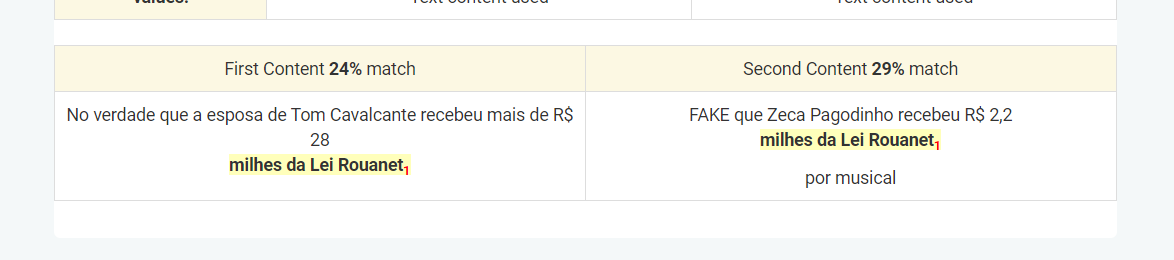

Similaridade = 0.28596130691066257

In [34]:
similaridade = cosine_similarity_text(
    "Um olhar sobre as fake news e uma perspectiva para 2024",
    "É #FAKE que g1 publicou reportagem sobre prêmio de R$ 1 milhão a quem citar sentenças que inocentam Lula"
)
ehSimilar(similaridade)

False

# Pesquisando nos textos obtidos

In [35]:
fatooufake = ler_json("./FatoouFake/fatofakeTeste1.json")
boatosorg = ler_json("./Boatos.org/boatosorg_ref.json")
# Deixar na lista Fato ou Fake, somente textos que não tem referencia
fatooufake = filter_by_attribute(fatooufake,"referencia","")

In [39]:
textosRepetidos = []
maximoTextos = int(len(boatosorg)) # para teste, limita o tamanho da base Boatos.org
attr_compare = "tituloLimpo" #Atributo que será usado para verificar a similaridade

similares_count = 0
print(len(fatooufake))

for index,texto_b in enumerate(boatosorg[0:maximoTextos]):
    
    # Limitar o número de textos na base fatooufake -> reduzir custo computacional
    # antes: 1500 * 1500 = 2.250.000
    # agora: 1500 * 60 = 90.000
    tamanhoFF = len(fatooufake)
    min_range,max_range = range_valid_text(index,tamanhoFF)
    fatofakeSimplificado = fatooufake[min_range:max_range]
    
    for texto_ff in fatofakeSimplificado:
        
        texto1,texto2 = texto_b[attr_compare], texto_ff[attr_compare]
        similaridade = cosine_similarity_text(
            " ".join(obterPalavrasTexto(texto1)),
            " ".join(obterPalavrasTexto(texto2)),
        )
        
        if ehSimilar(similaridade):
            similares_count += 1
            textosRepetidos.append([
                texto_b, texto_ff
            ])
            # Remover texto da lista Fato ou fake
            fatooufake.remove(texto_ff)
            # Se achou um similar não precisa de procurar mais
            break

print(similares_count)

1120
0


In [37]:
textosRepetidos

[]

In [26]:
# Salvar textos obtidos em .json

with open(f"./VerificaRepeticao/similares.json",'w+',encoding="utf8") as f:
    json.dump(textosRepetidos,f,indent=3,allow_nan=True,ensure_ascii = False)
    f.close()
with open(f"./VerificaRepeticao/semsimilares.json",'w+',encoding="utf8") as f:
    json.dump(fatooufake,f,indent=3,allow_nan=True,ensure_ascii = False)
    f.close()